**Desarrollado por:** Javier Fernando Botía Valderrama

*Docente del Departamento de Ingeniería de Sistemas*

**Materia:** Análisis Avanzado de Datos

**Departamento:** Ingeniería Aeroespacial

**Facultad de Ingeniería - Universidad de Antioquia**

# Análisis Estadístico Parte 2 - Métodos de Imputación de Datos y Función de Densidad Kernel

In [ ]:
import pandas as pd
import io
import requests
from scipy.stats import t # Distribución t - student
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind # t-test de dos muestras independientes
from sklearn.impute import MissingIndicator # Es una función que permite identificar los datos faltantes
from sklearn.impute import SimpleImputer # Método de imputación 
from sklearn.impute import KNNImputer # Se utiliza la función KNNIMputer para aplicar la imputación KNN
from sklearn.neighbors import KernelDensity # Densidad Kernel (Scikit-Learn)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import scipy.stats

**Base de datos phoneme**: sh como en she, dcl como en dark, iy como la vocal en she, aa como la vocal en dark y ao como la primera vocal en water.
Los datos categóricos están codificados en dos etiquetas 0 y 1, donde la clase 0 representa es sonido nasal y la clase 1 es sonido oral.
Sitio Web de la base de datos: https://sci2s.ugr.es/keel/dataset.php?cod=105

In [ ]:
url = "https://raw.githubusercontent.com/javierfernandobotia/AnalisisAvanzadoDatos/main/phoneme.dat"
download = requests.get(url).content
data = pd.read_table(io.StringIO(download.decode('utf-8')), sep=',',
                     decimal = ',')
# Esimportante codificarlo a utf-8
display(data.head(20))

,Aa,Ao,Dcl,Iy,Sh,Class
0,1.24,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.3,1.041,0.559,0
3,0.279,0.99,2.555,-0.738,0.0,0
4,0.307,1.272,2.656,-0.946,-0.467,0
5,0.96,0.712,-0.143,0.091,-0.061,0
6,2.941,0.657,1.493,-0.331,-0.123,0
7,0.401,1.159,2.064,-0.69,-0.308,0
8,0.229,1.748,0.634,0.259,0.0,0
9,0.303,0.609,0.474,1.427,-0.811,1


## Relación entre Variables Numérica y Nominales

### Función de Distribución de Probabilidad t-student

ncialmente, se define una distribución Gamma con dos parámetros $\alpha$ y $b$, el cual lo representamos como $Gam(\lambda\vert \alpha, b)$:

$$Gam(\lambda\vert \alpha, b) = \frac{1}{\Gamma(\alpha)}b^\alpha \lambda^{\alpha - 1} \exp(-b\lambda)$$

donde $\Gamma(\alpha)$ es la función Gamma que vimos en la unidad 1, $\lambda$ se llama como la **precisión** y $b$ es un parámetro de ajuste de la distribución. 

Considerando la anterior distribución y la distribución Gaussiana, se utiliza dos parámetros, $\nu = 2\alpha$ y $\lambda = \frac{\alpha}{b}$. De manera forma, la distribución t-student, $St(x\vert \mu, \lambda, \nu)$, se expresa como:

$$St(x\vert \mu, \lambda, \nu) = \frac{\Gamma \left( \frac{\nu}{2} + \frac{1}{2}\right )}{\Gamma \left (\frac{\nu}{2} \right)} \left (\frac{\lambda}{\pi\cdot \nu} \right)^{\frac{1}{2}} \left \lbrack 1 + \frac{\lambda (x - \mu)^2}{\nu} \right \rbrack^{-\frac{\nu}{2} - \frac{1}{2}}$$

El parámetro $\lambda$ se llama habitualmente como el **parámetro de precisión t-student** y el parámetro $\nu$ se llama **grados de libertad**. A diferencia de una distribución de densidad de probabilidad Gaussiana, la distribución t-student tiene una interesante propiedad llamada **robustez**, que significa que la distribución t-student es mucho menos sensible que la distribución Gaussiana cuando hay presencia de un conjunto de datos de tamaño pequeño (esta propiedad es interesante porque permite agrupar datos con presencia de datos atípicos u outliers de manera más eficiente, usando mezclas Gaussianas. Lo anterior **es útil para tareas de aprendizaje no supervisado en machine learning**). Otro detalle intersante de la robustez es su aplicabilidad en tareas de regresión, el cual es útil para obtener modelos robustos de regresión para hacer tareas de predicción. 

La media y la varianza de la distribución t-student se expresan como:

$$\mu = 0,\,\, Si\,\, \nu > 1$$
$$\sigma^2 = \frac{\nu}{\nu - 2},\,\, Si\,\, \nu > 2$$

Es importante mencionar que la media siempre se mantendrá en 0 si $\nu > 1$ porque para valores más pequeños, es decir $\nu \leq 1$, la media tiende a ser un valor indeterminado. Una interpretación similar se presenta con la varianza. 

Por otra parte, el sesgo y la curtosis de esta distribución se expresan como:

$$s = 0,\,\, Si\,\, \nu > 3$$
$$\beta_2 = \frac{6}{\nu - 4},\,\, Si\,\, \nu > 4$$

Observen que el sesgo siempre será 0 para $\nu > 3$ y la curtosis dependerá del grado de libertad que debe ser $\nu > 4$ para evitar valores indeterminados.

Veamos un ejemplo práctico de esta importante distribución.

Media_1 = 0.00; Media_2 = 0.00; Media_3 = 0.00; Media_4 = 0.00
Varianza_1 = 2.82; Varianza_2 = 1.25; Varianza_3 = 1.11; Varianza_4 = 1.06
Sesgo_1 = 0.00; Sesgo_2 = 0.00; Sesgo_3 = 0.00; Sesgo_4 = 0.00
Curtosis_1 = inf; Curtosis_2 = 1.00; Curtosis_3 = 0.38; Curtosis_4 = 0.19


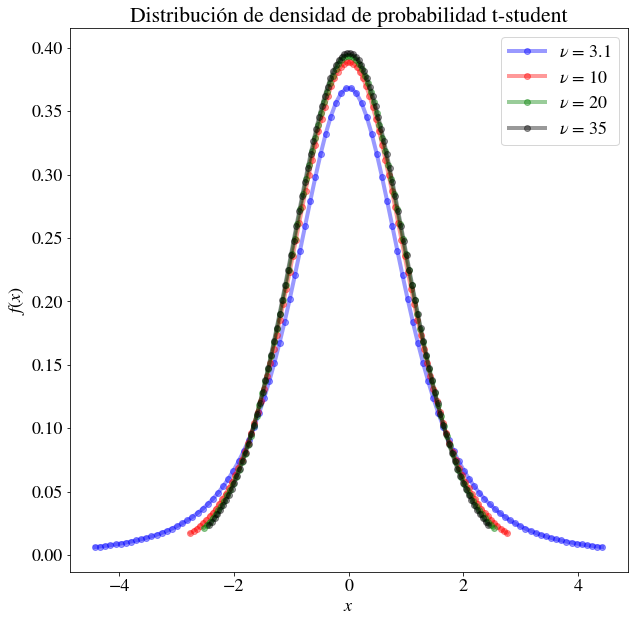

In [ ]:
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

nu_1, nu_2, nu_3, nu_4 = 3.1, 10, 20, 35

media_1, varianza_1, sesgo_1, kurtosis_1 = t.stats(nu_1, moments='mvsk')
media_2, varianza_2, sesgo_2, kurtosis_2 = t.stats(nu_2, moments='mvsk')
media_3, varianza_3, sesgo_3, kurtosis_3 = t.stats(nu_3, moments='mvsk')
media_4, varianza_4, sesgo_4, kurtosis_4 = t.stats(nu_4, moments='mvsk')

print("Media_1 = {:.2f};".format(media_1), "Media_2 = {:.2f};".format(media_2), "Media_3 = {:.2f};".format(media_3), "Media_4 = {:.2f}".format(media_4))
print("Varianza_1 = {:.2f};".format(varianza_1), "Varianza_2 = {:.2f};".format(varianza_2), "Varianza_3 = {:.2f};".format(varianza_3), "Varianza_4 = {:.2f}".format(varianza_4))
print("Sesgo_1 = {:.2f};".format(sesgo_1), "Sesgo_2 = {:.2f};".format(sesgo_2), "Sesgo_3 = {:.2f};".format(sesgo_3), "Sesgo_4 = {:.2f}".format(sesgo_4))
print("Curtosis_1 = {:.2f};".format(kurtosis_1), "Curtosis_2 = {:.2f};".format(kurtosis_2), "Curtosis_3 = {:.2f};".format(kurtosis_3), "Curtosis_4 = {:.2f}".format(kurtosis_4))

x1 = np.linspace(t.ppf(0.01, nu_1), t.ppf(0.99, nu_1), 100)
x2 = np.linspace(t.ppf(0.01, nu_2), t.ppf(0.99, nu_2), 100)
x3 = np.linspace(t.ppf(0.01, nu_3), t.ppf(0.99, nu_3), 100)
x4 = np.linspace(t.ppf(0.01, nu_4), t.ppf(0.99, nu_4), 100)

P1 = t.pdf(x1, nu_1)
P2 = t.pdf(x2, nu_2)
P3 = t.pdf(x3, nu_3)
P4 = t.pdf(x4, nu_4)

fig = plt.figure(figsize=(10,10))
plt.plot(x1, P1,'-ob', lw = 4, alpha = 0.4, label = r'$\nu$ = {:.1f}'.format(nu_1))
plt.plot(x2, P2,'-or', lw = 4, alpha = 0.4, label = r'$\nu$ = {:d}'.format(nu_2))
plt.plot(x3, P3,'-og', lw = 4, alpha = 0.4, label = r'$\nu$ = {:d}'.format(nu_3))
plt.plot(x4, P4,'-ok', lw = 4, alpha = 0.4, label = r'$\nu$ = {:d}'.format(nu_4))
plt.xlabel('$x$') # Etiqueta del eje x
plt.ylabel('$f(x)$') # Etiqueta del eje y  
plt.title('Distribución de densidad de probabilidad t-student') # Titulo de la gráfica
plt.legend()
plt.show()

**Notas**
- Media se mantiene en cero
- Varianza va disminuyendo a medida que los grados de libertad suben

### Test t

Teniendo en cuenta la distribución t-student visto en la secciones anteriores, nos enfocaremos en esta sección en el test t o prueba t. En dicha prueba, se analiza como las muestras se pueden modelar desde una población de distribución normal (Gaussiana) y como **la desviación estandar muestral se puede estimar como una varianza poblacional**, lo cual la distribución de las medias muestrales para una variable $x$ se puede determinar como:

$$t = \frac{\bar{x}-\mu}{(s/\sqrt{N})}$$

donde $\bar{x}$ es la media de una muestra de datos, $\mu$ es la media poblacional, $s$ es la desviación estándar poblacional y $N$ es el tamaño de las muestras de los datos.

Considerando la anterior ecuación, la prueba t se puede usar para comparar la media de una muestra con respecto a una población con una media conocida. Para este caso, la *hipótesis nula* esta establecida como no hay diferencias significativas entre la media en la población desde el cual la muestra esta definida y la media de la población conocida.

Lo anterior se interpreta de la siguiente forma:

**Por ejemplo**, se requiere conocer los efectos de la exposición al plomo en la inteligencia de los niños. Se sabe que para los niños de 5 años en los Estados Unidos en su conjunto, la puntuación media en un test de inteligencia particular es de 100. Si se tiene una muestra de 15 niños de 5 años que han sido expuestos al plomo, y quiere saber si esta exposición ha afectado la inteligencia según la medición de esta prueba en particular. También se sabe que los puntajes de inteligencia generalmente asumen una distribución Gaussiana en esta población. Por consiguiente, la hipótesis nula es que no hay diferencia en las puntuaciones de inteligencia del grupo expuesto al plomo y de la población en su conjunto, y realizará un test de dos colas con un valor de confianza $p = 0.05$.

A partir del ejemplo anterior, la ecuación del test t se transforma en **test t de una muestra:**

$$t = \frac{\bar{x}-\mu_0}{(s_0/\sqrt{N})}$$

donde \bar{x} es la media de la muestra, $\mu_0$ es la media de referencia que se conoce, $s_0$ es la desviación estándar de la muestra y $N$ es el tamaño de la muestra. Si consideramos el ejemplo de los efectos de la exposición al plomo en la inteligencia de los niños, se calcula $t$ como:

$$t = \frac{90-100}{(10/\sqrt{15})} = -3.87$$

Los grados de libertad para la prueba t de una muestra es $n-1$; en este ejemplo, $df = 15 - 1 = 14$. Si se determina el valor crítico superior para la distribución t, vemos que el valor crítico superior para una prueba t con 14
grados es $2.145$, si $pvalue \leq 0.025$. Debido a que el valor absoluto de la estadística t para los datos exceden el valor crítico superior $(\vert -3.87 \vert > 2.145)$, se rechaza la hipótesis nula de que los niños expuestos al plomo tengan el mismo promedio de puntaje en el test de inteligencia como los niños de su edad en toda la población. Por consiguiente, la diferencia de la media y las estadísticas t son negativas, también podemos decir que la media de la puntuación de la inteligencia es menor para los niños expuestos al plomo en comparación con el promedio de los niños de la misma edad en la población en su conjunto.

Para determinar el valor crítico, se debe calcular la función de probabilidad acumulada de la distribución t-student y luego localizar en $x$ cuando $p \leq 0.025$

**Notas**
- Se basa en la función de distribución de probabilidad anterior
- Más famoso para relaciones entre cuantitativos y cualitativos
- Analiza desviación estandar entre dos poblaciones
- De acuerdo al cálculo de desviación estandar se analiza si las variables cualitativas y cuantitativas se determina si dos variables están correlacionadas o no
- Por defecto se analizan máximo 100 muestras -> depende del tamaño de los datos
- El test se normaliza con el denominador (s/raiz(N))

El valor crítico superior con p = 0.025 es:  2.145213522769254


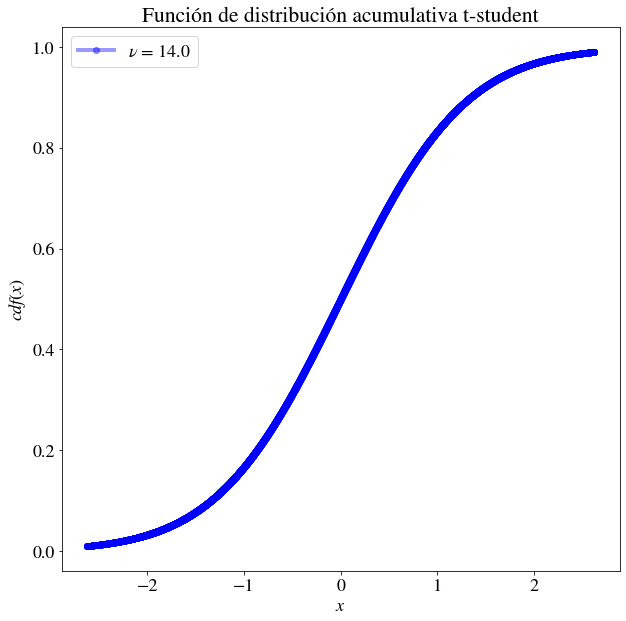

In [ ]:
from scipy.stats import t # Distribución t - student
import numpy as np
from matplotlib import pyplot
import matplotlib

matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

nu_1 = 14 # grados de libertad

x1 = np.linspace(t.ppf(0.01, nu_1), t.ppf(0.99, nu_1), 10000)
P1 = t.cdf(x1, nu_1)

pos_0025 = np.where(P1 <= 0.025)
p_0025 = np.where(x1[pos_0025] < 0) 
X_POS = np.abs(np.max(x1[p_0025]))
print("El valor crítico superior con p = 0.025 es: ", X_POS)

fig = pyplot.figure(figsize=(10,10))
pyplot.plot(x1, P1,'-ob', lw = 4, alpha = 0.4, label = r'$\nu$ = {:.1f}'.format(nu_1))
pyplot.xlabel('$x$') # Etiqueta del eje x
pyplot.ylabel('$cdf(x)$') # Etiqueta del eje y  
pyplot.title('Función de distribución acumulativa t-student') # Titulo de la gráfica
pyplot.legend()
pyplot.show()

Considerando la anterior explicación, vamos a explorar la estrategía para trabajar el test t con un conjunto de datos reales

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Aa      5404 non-null   object
 1    Ao     5404 non-null   object
 2    Dcl    5404 non-null   object
 3    Iy     5404 non-null   object
 4    Sh     5404 non-null   object
 5    Class  5404 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 253.4+ KB


In [ ]:
datos_phoneme_variables = data[['Aa', ' Ao', ' Dcl', ' Iy', ' Sh']] 
# Seleccionamos las variables o características o columnas de la base de datos
datos_phoneme_clases = data[' Class'] 
# Seleccionamos el vector de clases 

In [ ]:
datos_phoneme_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Aa      5404 non-null   object
 1    Ao     5404 non-null   object
 2    Dcl    5404 non-null   object
 3    Iy     5404 non-null   object
 4    Sh     5404 non-null   object
dtypes: object(5)
memory usage: 211.2+ KB


In [ ]:
datos_phoneme_variables = datos_phoneme_variables.astype(float)
datos_phoneme_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Aa      5404 non-null   float64
 1    Ao     5404 non-null   float64
 2    Dcl    5404 non-null   float64
 3    Iy     5404 non-null   float64
 4    Sh     5404 non-null   float64
dtypes: float64(5)
memory usage: 211.2 KB


In [ ]:
t_test = []
valor_p = []
Caracteristicas = ['Aa', ' Ao', ' Dcl', ' Iy', ' Sh']
nombres = ['norm', 'expon', 'chi2', 't', 'cauchy', 'beta'] 

# cauchy = distribución de densidad de probabilidad Cauchy
# chi2 = distribución de densidad de probabilidad chi - cuadrada
# expon = función de densidad de probabilidad exponencial
# norm = función de densidad de probabilidad normal
# beta = función de densidad de probabilidad beta

for distribuciones in nombres:
  dis = getattr(scipy.stats, distribuciones)
  par = dis.fit(datos_phoneme_variables.values)
  if distribuciones == 'norm' or 'expon' or 'cauchy':
    media = par[0]
  elif distribuciones == 'chi2' or 't':
    media = par[1]
  elif distribuciones == 'beta':
    media = par[2]
  for _,n in enumerate(Caracteristicas):
    valor_t_test, p_value = ttest_1samp(datos_phoneme_variables[n], media) # test _t de 1 muestra poblacional
    valor_p.append(p_value)
    t_test.append(valor_t_test)

valor_p = np.asarray(valor_p)
valor_p = valor_p.reshape(len(nombres), len(Caracteristicas))
t_test = np.asarray(t_test)
t_test = t_test.reshape(len(nombres), len(Caracteristicas))

t_test = pd.DataFrame(t_test, index = nombres, columns = Caracteristicas)
valor_p = pd.DataFrame(valor_p, index = nombres, columns = Caracteristicas)

display(t_test)
print('\n')
display(valor_p)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


,Aa,Ao,Dcl,Iy,Sh
norm,13.267655,51.379849,8.003952,-24.477898,-74.754178
expon,226.164935,266.197256,205.556087,205.044779,242.852219
chi2,-1290.440629,-1264.086614,-1201.736039,-1429.994281,-2019.664372
t,-2830.106560,-2817.638831,-2630.426391,-3089.894518,-4316.583091
cauchy,32.196656,70.479571,25.568595,-4.070709,-46.515340
beta,-659.948778,-627.908340,-616.688589,-750.266586,-1079.078165


,Aa,Ao,Dcl,Iy,Sh
norm,1.474218e-39,0.0,1.463228e-15,1.410140e-125,0.0
expon,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
chi2,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
t,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
cauchy,3.223889e-208,0.0,3.241322e-136,4.753954e-05,0.0
beta,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0


*   $H_0$ = No hay diferencias entre la media conocida de los datos y la media calculada por una determinada distribución de densidad de probabilidad.
*   $H_A$ = Hay diferencias entre la media conocida de los datos y la media calculada por una determinada distribución de densidad de probabilidad. En este caso, el valor real de la media poblacional de los datos suele ser mayor o menor al valor de la media que establece $H_0$.

Al realizar el test t con la base de datos para diferentes distribuciones de densidad de probabilidad, en todas las pruebas se encontró que el valor p es 0. Este resultado significa que hay evidencias significativas para rechazar $H_0$ en favor de $H_A$.

Otra estrategía comparativa que recomiendo es comparar cada característica o variable de la base de datos con respecto al vector de clases (categórico). Veamos que resultado encontramos para esta parte del análisis:

In [ ]:
t_test = []
valor_p = []
Caracteristicas = ['Aa', ' Ao', ' Dcl', ' Iy', ' Sh']
nombres = ['norm', 'expon', 'chi2', 't', 'cauchy', 'beta'] 

for distribuciones in nombres:
  t_test = []
  valor_p = []
  for n in Caracteristicas:
    Datos_numericos_categoricos = pd.concat([datos_phoneme_variables[n], datos_phoneme_clases], axis = 1)
    dis = getattr(scipy.stats, distribuciones)
    par = dis.fit(Datos_numericos_categoricos.values)
    if distribuciones == 'norm' or 'expon' or 'cauchy':
      media = par[0]
    elif distribuciones == 'chi2' or 't':
      media = par[1]
    elif distribuciones == 'beta':
      media = par[2]
    valor_t_test, p_value = ttest_1samp(Datos_numericos_categoricos, media) # test _t de 1 muestra poblacional
    p_value = np.asarray(p_value)
    valor_t_test = np.asarray(valor_t_test)
    valor_p.append(p_value)
    t_test.append(valor_t_test)
  valor_p = np.asarray(valor_p)
  t_test = np.asarray(t_test)
  t_test = pd.DataFrame(t_test, index = Caracteristicas, columns = ['test_t_variable_numerica', 'test_t_variable_categorica'])
  valor_p = pd.DataFrame(valor_p, index = Caracteristicas, columns = ['valor_p_variable_numerica', 'valor_p_variable_categorica'])
  print("Tabla valores test t - {:s}".format(distribuciones))
  display(t_test)
  print("Tabla valores p con test t - {:s}".format(distribuciones))
  display(valor_p)
  del valor_p
  del t_test      

Tabla valores test t - norm


,test_t_variable_numerica,test_t_variable_categorica
Aa,22.491489,-42.411339
Ao,41.690606,-77.911693
Dcl,18.716654,-38.034733
Iy,4.857055,-8.495351
Sh,-13.720166,17.342193


Tabla valores p con test t - norm


,valor_p_variable_numerica,valor_p_variable_categorica
Aa,3.657627e-107,0.000000e+00
Ao,0.000000e+00,0.000000e+00
Dcl,8.648902e-76,1.070887e-280
Iy,1.225056e-06,2.522396e-17
Sh,3.883663e-42,1.314101e-65


Tabla valores test t - expon


,test_t_variable_numerica,test_t_variable_categorica
Aa,215.635512,321.792952
Ao,223.354192,261.582470
Dcl,205.556087,341.647883
Iy,182.710582,302.583709
Sh,174.017526,254.641315


Tabla valores p con test t - expon


,valor_p_variable_numerica,valor_p_variable_categorica
Aa,0.0,0.0
Ao,0.0,0.0
Dcl,0.0,0.0
Iy,0.0,0.0
Sh,0.0,0.0


Tabla valores test t - chi2


,test_t_variable_numerica,test_t_variable_categorica
Aa,-1980.924404,-3820.175997
Ao,-1112.637600,-2235.128211
Dcl,-1582.150504,-3291.210041
Iy,-1856.856739,-3264.771396
Sh,-2522.255303,-3153.428577


Tabla valores p con test t - chi2


,valor_p_variable_numerica,valor_p_variable_categorica
Aa,0.0,0.0
Ao,0.0,0.0
Dcl,0.0,0.0
Iy,0.0,0.0
Sh,0.0,0.0


Tabla valores test t - t


,test_t_variable_numerica,test_t_variable_categorica
Aa,37.867107,-13.418125
Ao,-797.837621,-1646.827839
Dcl,-16183.230964,-32962.550479
Iy,26.013079,28.508110
Sh,-38.779014,-14.332014


Tabla valores p con test t - t


,valor_p_variable_numerica,valor_p_variable_categorica
Aa,1.631473e-278,2.088120e-40
Ao,0.000000e+00,0.000000e+00
Dcl,0.000000e+00,0.000000e+00
Iy,1.178289e-140,1.187205e-166
Sh,1.867280e-290,9.442743e-46


Tabla valores test t - cauchy


,test_t_variable_numerica,test_t_variable_categorica
Aa,55.865242,20.520270
Ao,60.539801,-42.686188
Dcl,48.676004,22.846657
Iy,33.111175,40.923208
Sh,10.787708,48.319973


Tabla valores p con test t - cauchy


,valor_p_variable_numerica,valor_p_variable_categorica
Aa,0.000000e+00,3.601116e-90
Ao,0.000000e+00,0.000000e+00
Dcl,0.000000e+00,2.312382e-110
Iy,4.644588e-219,0.000000e+00
Sh,7.376222e-27,0.000000e+00


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Tabla valores test t - beta


,test_t_variable_numerica,test_t_variable_categorica
Aa,-832.153341,-1653.982378
Ao,-510.548346,-1109.939658
Dcl,-127.237128,-334.632260
Iy,-865.200116,-1530.290126
Sh,-278.823839,-317.746985


Tabla valores p con test t - beta


,valor_p_variable_numerica,valor_p_variable_categorica
Aa,0.0,0.0
Ao,0.0,0.0
Dcl,0.0,0.0
Iy,0.0,0.0
Sh,0.0,0.0


Analizando estos resultados, se puede concluir que en todas las pruebas se encontró que el valor p es 0. Este resultado significa que hay evidencias significativas para rechazar $H_0$ en favor de $H_A$.

Hasta el momento, solo se ha analizado con una sola variable pero qué sucede si tenemos dos muestras independientes?. Para resolver esta inquietud, se establece el **test t de dos muestras**. El proposito de ese test es determinar si las medias de las poblaciones de las que se extrajeron las muestras son iguales. Para este caso, se supone que las dos muestras no están relacionados entre sí y que han sido seleccionados independientemente de sus poblaciones. Además, suponemos que las poblaciones de las que se seleccionaron las muestras tienen una distribución normal o Gaussiana, al menos que las muestras sean suficientemente grandes para invocar el teorema del límite central, y que las poblaciones tienen una varianza aproximadamente igual. 

Basado en el anterior enfoque del test t, se determina que:

$$t = \frac{(\bar{x_1}-\bar{x_2}) - (\mu_1 - \mu_2)}{\sqrt{s_p^2 \left( \frac{1}{N_1}+\frac{1}{N_2} \right)}}$$

donde:

$$s_p^2 = \frac{(n_1 - 1)s_1^2 + (n_1 - 1)s_2^2}{N_1 + N_2 - 2}$$

siendo $\bar{x_1}$ y $\bar{x_2}$ dos medias de dos muestras independientes, $\mu_1$ y $\mu_2$ son las medias de dos poblaciones, $s_p^2$ es la varianza acumulada, $s_1^2$ y $s_2^2$ son las varianzas de dos muestras y $N_1$ y $N_2$ son dos tamaños de dos muestras.

Veamos ejemplos prácticos del test t.

In [ ]:
t_test = []
valor_p = []
  
for n in Caracteristicas:
  Datos_numericos_categoricos = pd.concat([datos_phoneme_variables[n], datos_phoneme_clases], axis = 1)
  valor_t_test, p_value = ttest_ind(datos_phoneme_variables[n], datos_phoneme_clases, equal_var = True) # test _t de 2 muestras poblacionales
  t_test.append(valor_t_test)
  valor_p.append(p_value)

indices = ['Aa / Clases', 'Ao / Clases', 'Dcl / Clases', 'Iy / Clases', 'Sh / Clases']
columnas = ['valor test t', 'valor p']

resultados = np.vstack([t_test, valor_p]).T # Se aplica la transpuesta a la matriz de resultados
resultados = pd.DataFrame(resultados, index = indices, columns = columnas)
display(resultados)

,valor test t,valor p
Aa / Clases,39.740512,0.000000e+00
Ao / Clases,73.517636,0.000000e+00
Dcl / Clases,33.586913,2.499919e-235
Iy / Clases,8.433111,3.794182e-17
Sh / Clases,-21.519954,1.287620e-100


Analizando estos resultados, se toma la decisión de rechazar $H_0$ y concluir que existe una diferencia estadísticamente significativa entre las dos muestras (comparando una variable numérica y el vector de clases).

**Notas**
- Más robusto que el anterior
- Mirar si las medias entre una variable categórica y numérica están correlacionadas
- De acuerdo a los resultados: variables independientes
- Si valor p fuera mayor a 0.05, si habría dependencia
- A los estadísticos les gusta ANOVA

## Métodos de Imputación de Datos

La imputación de datos es un conjunto de métodos para evitar la eliminación de muestras u observaciones útiles y valiosos para analizar datos cuando hay presencia de **datos faltantes o datos nulos**. Por lo general, la imputación de datos utiliza técnicas de interpolación para estimar valores en los datos faltantes. Existen varias estrategías para imputar datos basados en *estadísticos o en algoritmos de vecinos más cercanos*. A continuación, vamos a revisar algunos de ellos:

**Notas**
Imputación de datos:
- Métodos para rellenar datos faltantes, de modo que no altere la orginalidad de los datos
- Evitar generar mayor sesgo al rellenar datos faltantes

*Descripción original de los datos*: 

This data set can be used to predict the severity (benign or malignant) of a mammographic mass lesion from BI-RADS attributes and the patient's age.

It contains a BI-RADS assessment, the patient's age and three BI-RADS attributes together with the ground truth (the severity field, which is the target attribute).

The data was collected at the Institute of Radiology of the University Erlangen-Nuremberg between 2003 and 2006.

https://sci2s.ugr.es/keel/dataset.php?cod=86

In [ ]:
url = "https://raw.githubusercontent.com/javierfernandobotia/AnalisisAvanzadoDatos/main/mammographic.dat"
download = requests.get(url).content
data = pd.read_table(io.StringIO(download.decode('utf-8')), sep=',',
                     decimal = ',')
# Esimportante codificarlo a utf-8
display(data.head(20))

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1
5,4,65,1,?,3,0
6,4,70,?,?,3,0
7,5,42,1,?,3,0
8,5,57,1,5,3,1
9,5,60,?,5,1,1


Severity: si tiene cancer de seno

### Estrategía de Diagnóstico de Datos Faltantes

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BI-RADS   961 non-null    object
 1   Age       961 non-null    object
 2   Shape     961 non-null    object
 3   Margin    961 non-null    object
 4   Density   961 non-null    object
 5   Severity  961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


**NOTA:** Es importante que el número de muestras de cada característica sea igual al número de muestras o filas de la base de datos original. Sin embargo, este tipo de exploración de datos no garantiza que exista datos faltantes o con caracteres extraños. Por esta razón, se recomienda hacer una exploración exhaustiva de la base de datos.

In [ ]:
BI_RADS = list(data['BI-RADS'].value_counts().index)
Age = list(data['Age'].value_counts().index)
Shape = list(data['Shape'].value_counts().index)
Margin = list(data['Margin'].value_counts().index)
Density  = list(data['Density'].value_counts().index)
Severity  = list(data['Severity'].value_counts().index)
display([[BI_RADS,Age,Shape,Margin,Density,Severity]])

[[['4', '5', '3', '2', '6', '0', '?'],
  ['59',
   '67',
   '57',
   '66',
   '46',
   '64',
   '55',
   '60',
   '54',
   '62',
   '65',
   '63',
   '53',
   '49',
   '58',
   '56',
   '71',
   '50',
   '45',
   '43',
   '52',
   '68',
   '42',
   '40',
   '44',
   '72',
   '76',
   '41',
   '51',
   '47',
   '35',
   '61',
   '70',
   '69',
   '74',
   '48',
   '80',
   '39',
   '36',
   '34',
   '77',
   '38',
   '73',
   '33',
   '37',
   '79',
   '31',
   '75',
   '23',
   '27',
   '32',
   '21',
   '83',
   '86',
   '28',
   '?',
   '87',
   '78',
   '85',
   '19',
   '24',
   '84',
   '29',
   '25',
   '30',
   '22',
   '26',
   '81',
   '88',
   '18',
   '82',
   '93',
   '96',
   '20'],
  ['4', '1', '2', '3', '?'],
  ['1', '4', '5', '3', '?', '2'],
  ['3', '?', '2', '1', '4'],
  [0, 1]]]

Como se sospechaba, hay datos faltantes "?" en varias características de nuestra base de datos. El siguiente paso, es convertir los datos "?" en datos "NaN" o nulos, con la finalidad de calcular un porcentaje total de datos faltantes de nuestra base de datos

In [ ]:
data = data.replace("?",np.nan) # Reemplazamos los datos ? por datos NaN o nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BI-RADS   959 non-null    object
 1   Age       956 non-null    object
 2   Shape     930 non-null    object
 3   Margin    913 non-null    object
 4   Density   885 non-null    object
 5   Severity  961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


Debido al análisis exploratorio exhaustivo, se descubrió que en realidad hay datos faltantes en nuestra base de datos. Vamos a calcular un porcentaje de los datos faltantes de nuestra base de datos.

In [ ]:
Indicador = MissingIndicator(missing_values = np.nan) # Decimos que datos debe buscar como datos faltantes
Indicador.fit(data) # Aplicamos el método de búsqueda con nuestra base de datos
Datos_Indicador = Indicador.transform(data) # Realizamos una transformación Booleana de los datos para identificar los datos faltantes (True)
                                             # y los datos no faltantes (False)
display(Datos_Indicador) # Mostramos los resultados de la búsqueda de los datos faltantes y no faltantes

array([[False, False, False, False, False],
       [False, False, False, False,  True],
       [False, False, False, False, False],
       ...,
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [ ]:
print("Características donde hay datos faltantes: ", Indicador.features_)

Características donde hay datos faltantes:  [0 1 2 3 4]


Lo anterior indica que las caracterpisticas *MaritalStatus*, *Education*, *Occupation*, *YearsInSf*, *HouseholdMembers*, *HouseholdStatus*, *TypeOfHome*, *EthnicClass* y *Language*, tienen datos faltantes

In [ ]:
POS = np.where(Datos_Indicador == True) # Se busca aquellos datos que tiene un valor Booleanos igual a True
print("Porcentaje de Datos Faltantes (%): ", 100*(len(POS[0])/(Datos_Indicador.shape[0]*Datos_Indicador.shape[1])))

Porcentaje de Datos Faltantes (%):  3.3714880332986477


% datos faltantes = 100 x (pos-faltante/(N x D))
- N: # filas o muestras de la base de datos
- D: # variables o características
- pos-faltante: # datos faltantes

Lo anterior indica que hay 3.37 % de datos faltantes. Ahora viene la siguiente pregunta: ¿Cómo rellenar los datos faltantes?. La principal estrategía es la **Imputación de datos**

### Imputación Simple

**Notas**
- Imputación simple: rellena datos faltantes de acuerdo a un estadístico

#### Imputación de la media

Es un método que sustituye los valores faltantes por el valor promedio de cada característica de los datos. A continuación, se muestra un ejemplo práctico:

In [ ]:
imp = SimpleImputer(missing_values = np.nan, strategy= 'mean') # Rellena los datos NaN por medio del cálculo de la media
imp.fit(data) # Aplicamos el método con los datos
Datos_Imputacion_Media = imp.transform(data) # Realizamos la imputación de la media con nuestros datos
nombres = data.columns
Datos_Imputacion_Media = pd.DataFrame(Datos_Imputacion_Media, columns = nombres)
display(Datos_Imputacion_Media)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.000000,1.0
1,4.0,43.0,1.0,1.0,2.910734,1.0
2,5.0,58.0,4.0,5.0,3.000000,1.0
3,4.0,28.0,1.0,1.0,3.000000,0.0
4,5.0,74.0,1.0,5.0,2.910734,1.0
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.000000,0.0
957,4.0,56.0,4.0,5.0,3.000000,1.0
958,4.0,64.0,4.0,5.0,3.000000,0.0
959,5.0,66.0,4.0,5.0,3.000000,1.0


In [ ]:
Datos_Imputacion_Media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float64
 1   Age       961 non-null    float64
 2   Shape     961 non-null    float64
 3   Margin    961 non-null    float64
 4   Density   961 non-null    float64
 5   Severity  961 non-null    float64
dtypes: float64(6)
memory usage: 45.2 KB


Como se puede observar, se logró rellenar los datos faltantes y el tipo de dato ahora es Float 64 bits, logrando reducir un poco el uso de memoría para almacenar los datos.

#### Imputación de la mediana

Es un método que sustituye los valores faltantes por el valor de la mediana de cada característica de los datos. A continuación, se muestra un ejemplo práctico:

In [ ]:
imp_2 = SimpleImputer(missing_values = np.nan, strategy= 'median') # Rellena los datos NaN por medio del cálculo de la mediana
imp_2.fit(data)
Datos_Imputacion_Mediana = imp_2.transform(data)
nombres = data.columns
Datos_Imputacion_Mediana = pd.DataFrame(Datos_Imputacion_Mediana, columns = nombres)
display(Datos_Imputacion_Mediana)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1.0
1,4.0,43.0,1.0,1.0,3.0,1.0
2,5.0,58.0,4.0,5.0,3.0,1.0
3,4.0,28.0,1.0,1.0,3.0,0.0
4,5.0,74.0,1.0,5.0,3.0,1.0
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.0,0.0
957,4.0,56.0,4.0,5.0,3.0,1.0
958,4.0,64.0,4.0,5.0,3.0,0.0
959,5.0,66.0,4.0,5.0,3.0,1.0


**Notas**
- Cuando tengamos variables con valores enteros positivos, se usa la mediana
- Cuando son valores flotantes, se usa la media

In [ ]:
Datos_Imputacion_Mediana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float64
 1   Age       961 non-null    float64
 2   Shape     961 non-null    float64
 3   Margin    961 non-null    float64
 4   Density   961 non-null    float64
 5   Severity  961 non-null    float64
dtypes: float64(6)
memory usage: 45.2 KB


#### Imputación con los datos más frecuentes

Es un método que reemplaza los valores faltantes por los valores más frecuentes de cada características de los datos. A continuación, se muestra un ejemplo práctico:

In [ ]:
imp_3 = SimpleImputer(missing_values = np.nan, strategy= 'most_frequent') # Rellena los datos NaN por medio del cálculo de los valores más frecuentes
imp_3.fit(data)
Datos_Imputacion_Frecuente = imp_3.transform(data)
nombres = data.columns
Datos_Imputacion_Frecuente = pd.DataFrame(Datos_Imputacion_Frecuente, columns = nombres)
display(Datos_Imputacion_Frecuente)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,3,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


In [ ]:
Datos_Imputacion_Frecuente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BI-RADS   961 non-null    object
 1   Age       961 non-null    object
 2   Shape     961 non-null    object
 3   Margin    961 non-null    object
 4   Density   961 non-null    object
 5   Severity  961 non-null    object
dtypes: object(6)
memory usage: 45.2+ KB


Como pueden observar, este método genera que cada característica de los datos sea tipo **object** pero es mejor convertirlo a datos enteros o datos tipo flotante para manipular mejor los datos.

In [ ]:
for i in range(0, len(Datos_Imputacion_Frecuente.columns)):
    Datos_Imputacion_Frecuente.iloc[:,i] = pd.to_numeric(Datos_Imputacion_Frecuente.iloc[:,i], 
                                                         errors='ignore', downcast = 'float')
Datos_Imputacion_Frecuente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float32
 1   Age       961 non-null    float32
 2   Shape     961 non-null    float32
 3   Margin    961 non-null    float32
 4   Density   961 non-null    float32
 5   Severity  961 non-null    float32
dtypes: float32(6)
memory usage: 22.6 KB


Observen que esta estretegia reduce aún más el uso de memoría - Una pequeña Ñapa de la experiencia :) 

### Imputación con el Algoritmo de los Vecinos más Cercanos

Es un método de imputación basado en el algoritmo de los vecinos más cercanos o KNN. Este método rellena los valores faltantes por medio de un cálculo de la distancia euclidiana de los vecinos más cercanos y a cada característica, se imputa los valores faltantes a través de un promedio uniforme. Sin embargo, si a cada característica le falta más de un valor, los vecinos para esa muestra pueden ser diferentes dependiendo de la característica particular que se imputa. Es importante tener en cuenta que si el número de vecinos que define el usuario es menor al número de vecinos que se puede determinar en los datos, y además que no hay distancias euclidianas que se puedan calcular, la imputación se realiza por un promedio de los valores existentes (como en la imputación por la media). En caso que hay al menos un vecino con distancia calculada, se aplica un promedio ponderado o no ponderado con los vecinos restantes.

**Notas**

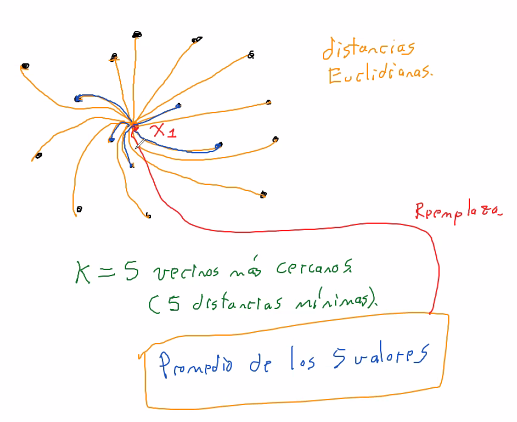

In [ ]:
from IPython.display import Image
Image(filename="vecinos.png")

In [ ]:
imp_4 = KNNImputer(missing_values = np.nan, n_neighbors = 5, weights= "uniform")  # pdf uniforme P = N_a/N
# Imputación por el algoritmo KNN con 5 vecinos y promedio uniforme.
imp_4.fit(data)
Datos_Imputacion_KNN_1 = imp_4.transform(data)

In [ ]:
imp_5 = KNNImputer(missing_values = np.nan, n_neighbors = 5, weights= "distance")  # distacia euclidiana
# Imputación por el algoritmo KNN con 5 vecinos y promedio ponderado donde 
# los vecinos más cercanos de un valor tendrán una mayor influencia que los vecinos que están más lejos.
imp_5.fit(data)
Datos_Imputacion_KNN_2 = imp_5.transform(data)

**Notas**
- Opción de distance es más precisa

In [ ]:
Datos_Imputacion_KNN_1 = pd.DataFrame(Datos_Imputacion_KNN_1, columns = nombres)
Datos_Imputacion_KNN_2 = pd.DataFrame(Datos_Imputacion_KNN_2, columns = nombres)

In [ ]:
Datos_Imputacion_KNN_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float64
 1   Age       961 non-null    float64
 2   Shape     961 non-null    float64
 3   Margin    961 non-null    float64
 4   Density   961 non-null    float64
 5   Severity  961 non-null    float64
dtypes: float64(6)
memory usage: 45.2 KB


In [ ]:
Datos_Imputacion_KNN_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float64
 1   Age       961 non-null    float64
 2   Shape     961 non-null    float64
 3   Margin    961 non-null    float64
 4   Density   961 non-null    float64
 5   Severity  961 non-null    float64
dtypes: float64(6)
memory usage: 45.2 KB


**Nota:** Se sugiere usar un número de vecinos más cercanos en valores impares, es decir, $\lbrace 3, 5, 7, 9, 11, 13, \ldots \rbrace$. Sugiero hacer una lectura del siguiente Blog que explica en detalle esta recomendación: \url{https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/}

Hasta este punto, tenemos cuatro estrategías para imputar datos, pero, ¿Cúal seleccionamos para seguir con nuestra exploración de datos?. Si analizamos los datos, todos los datos son enteros positivos, por consiguiente, la imputación de la media no se seleccionaría porque genere datos rellenados con valores reales o con decimales en el lenguaje común. Por consiguiente, se seleccionará los datos con imputación a la mediana porque los datos son enteros positivos, aunque los otros métodos como los datos más frecuentes o KNN genera valores enteros positivos. El criterio de selección depende del analizador de datos.

Nuestro siguiente paso es la facinante estrategía de la detección de datos atípicos o también llamado en el mundo de los científicos de datos como outliers. Analicemos con nuestra base de datos si hay presencia o no de datos atípicos y las precauciones que se deben considerar.

## Función de Densidad Kernel

Cuando se trabaja en escenarios reales, uno de los puntos de interes es encontrar la representación continua de una distribución de probabilidad con un conjunto de datos. Para lograr este objetivo, se estima una distribución no paramétrica que evite hasta lo posible la dependencia de parámetros de una función de densidad de probabilidad. En este caso, se utiliza una estrategía llamada **estimación de densidad Kernel**, que mediante un conjunto de datos obtenidos sin conocer su distribución de probabilidad, queremos estimar la representación continua de su distribución. Por lo general, existen varias funciones kernel como el **Kernel Lineal**, **Kernel Gaussiano**, **Kernel Sigmoidal** (para esta unidad, no nos centraremos en la parte matemática de la densidad Kernel debido a que es un tema extenso. Solamente nos centraremos en la parte fundamental), entre otras que generan la densidad alrededor de los datos.

In [ ]:
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
data_Density = Datos_Imputacion_KNN_2['Density'].values
data_Density = data_Density.reshape(-1, 1) # Es importante que los datos esten entre 1 y -1
kde.fit(data_Density)

In [ ]:
x_minimo_comp_1 = np.min(Datos_Imputacion_KNN_2['Density'].values)
x_maximo_comp_1 = np.max(Datos_Imputacion_KNN_2['Density'].values)
x = np.linspace(x_minimo_comp_1, x_maximo_comp_1, data_Density.shape[0]) # generamos un vector de datos desde el precio mínimo hasta el precio máximo de la compañia 1
Prob_Log = kde.score_samples(x.reshape(-1, 1)) # Es importante que los datos esten entre 1 y -1
                                               # Log = Logarítmico

matplotlib.rcParams.update({'font.size': 20, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

fig = plt.figure(figsize=(12,8))

plt.fill_between(x, np.exp(Prob_Log), alpha = 0.7) # Se muestra la función de densidad de probabilidad estimado por densidad kernel
plt.plot(x, np.exp(Prob_Log), 'r', linewidth = 4) # Se muestra la función de densidad de probabilidad estimado por densidad kernel
plt.xlabel("Density")
plt.ylabel("Probabilidad")
plt.show()

Como pueden observar, el kernel gaussiano permitio construir una función de densidad de probabilidad para la variable Density 

In [ ]:
matplotlib.rcParams.update({'font.size': 20, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

fig = plt.figure(figsize=(12,8))

plt.hist(Datos_Imputacion_KNN_2['Density'], bins = 60, alpha=0.7, density = True) # fd = regla de Freedman-Diaconis
plt.xlim(Datos_Imputacion_KNN_2['Density'].min(), Datos_Imputacion_KNN_2['Density'].max()) # Límita el valor mínimo y máximo en eje x de la gráfica
plt.xlabel('Density')
plt.ylabel('Frecuencias')
plt.title('Histograma de Density')
plt.show()

unque es un método muy interesante para estimar una distribución de probabilidad sin necesidad de calcular la media o la desviación estándar (es decir, este es un método no paramétrico). No obstante, uno de los inconvenientes es establecer el valor más apropiado del ancho de banda o **bandwidth** que permita mejorar la construcción de la función de densidad de probabilidad. Como este método se utiliza en escenarios de Machine Learning, vamos a utilizar una técnica llamada **gridsearch**, el cual permite encontrar el ancho de banda óptimo para nuestro caso de interés

In [ ]:
ancho_de_banda = np.linspace(-2, 2, 200) # Rango de valores de ancho de banda

GS = GridSearchCV(KernelDensity(kernel='gaussian'), 
                  {'bandwidth': ancho_de_banda}, cv = 10, error_score = 1e-5) # cv = número de doblajes a los datos
GS.fit(Datos_Imputacion_KNN_2['Density'].values.reshape(-1, 1)) 

In [ ]:
ancho_banda_optimo = GS.best_params_
print("Ancho de banda óptimo = ", ancho_banda_optimo)

In [ ]:
kde_opt = KernelDensity(bandwidth = 0.010050251256281229, kernel='gaussian')
kde_opt.fit(data_Density)

In [ ]:
Prob_Log_opt = kde_opt.score_samples(x.reshape(-1, 1)) # Es importante que los datos esten entre 1 y -1

matplotlib.rcParams.update({'font.size': 20, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

fig = plt.figure(figsize=(12,8))

plt.fill_between(x, np.exp(Prob_Log_opt), alpha = 0.7, color = 'm') # Se muestra la función de densidad de probabilidad estimado por densidad kernel
plt.plot(x, np.exp(Prob_Log_opt), 'b', linewidth = 4) # Se muestra la función de densidad de probabilidad estimado por densidad kernel
plt.xlabel("Density")
plt.ylabel("kernel")
plt.show()

¿Qué sucedería si cambiamos la función kernel?

In [ ]:
kernels = ['gaussian', 'cosine', 'epanechnikov', 'exponential', 'linear', 'tophat']
colores = ['r', 'm', 'g', 'brown', 'ForestGreen', 'orange']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
arreglo = np.arange(6) + 231

for k, indice in zip(kernels, arreglo):
    kde = KernelDensity(kernel=k, bandwidth = 0.010050251256281229)
    kde.fit(data_Density)
    Prob_Log = kde.score_samples(x.reshape(-1, 1))
    plt.subplot(indice)
    plt.fill_between(x, np.exp(Prob_Log), alpha = 0.5, color = 'm')
    plt.plot(x, np.exp(Prob_Log), 'r', linewidth = 1.5) # Se muestra la función de densidad de probabilidad estimado por densidad kernel
    plt.hist(Datos_Imputacion_KNN_2['Density'], bins = 60, alpha=0.6, density = True) # fd = regla de Freedman-Diaconis
    plt.xlabel("Density")
    plt.ylabel("Probabilidad")
    plt.title(k)

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

¿Cómo se puede aplicar la función de densidad Kernel para todas las características de una forma inmediata?

In [ ]:
scatter = pd.plotting.scatter_matrix(Datos_Imputacion_KNN_2, alpha=1.0, figsize=(17,17), range_padding = 0.1, diagonal='hist',
                           color = 'b', hist_kwds = {'bins':60, 'color':'red'}) # Grafica de dispersión e histograma
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 28, rotation = 0)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 28, rotation = 90)
    ax.tick_params(axis = 'both', labelsize = 24)

plt.show()

In [ ]:
scatter = pd.plotting.scatter_matrix(Datos_Imputacion_KNN_2, alpha=1.0, figsize=(17,17), range_padding = 0.1, diagonal='kde',
                           color = 'm' ) # Grafica de dispersión e histograma
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 28, rotation = 0)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 28, rotation = 90)
    ax.tick_params(axis = 'both', labelsize = 24)

plt.show()

In [ ]:
característica_1 = 0
característica_2 = 4

x_1, y_1 = scatter[característica_1,característica_1].get_lines()[0].get_data()
x_2, y_2 = scatter[característica_2,característica_2].get_lines()[0].get_data()

plt.plot(x_1,y_1,'-', color = 'b')
plt.fill_between(x_1, y_1, color='blue', alpha=0.5)
plt.plot(x_2,y_2,'-', color = 'r')
plt.fill_between(x_2, y_2, color='red', alpha=0.5)
plt.xlabel('x')
plt.ylabel('Valores de las Características')
plt.show()

In [ ]:
Data_Features = Datos_Imputacion_KNN_2[['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']]
Data_Features_Normalizados = (Data_Features - Data_Features.min())/(Data_Features.max() - Data_Features.min())

scatter_normalizados = pd.plotting.scatter_matrix(Data_Features_Normalizados, alpha=1.0, figsize=(17,17), range_padding = 0.1, diagonal='kde',
                           color = 'm' ) # Grafica de dispersión e histograma
for ax in scatter_normalizados.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 28, rotation = 0)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 28, rotation = 90)
    ax.tick_params(axis = 'both', labelsize = 22)

plt.show()

In [ ]:
característica_1 = 0
característica_2 = 4

x_1, y_1 = scatter_normalizados[característica_1,característica_1].get_lines()[0].get_data()
x_2, y_2 = scatter_normalizados[característica_2,característica_2].get_lines()[0].get_data()

plt.plot(x_1,y_1,'-', color = 'b')
plt.fill_between(x_1, y_1, color='blue', alpha=0.5)
plt.plot(x_2,y_2,'-', color = 'r')
plt.fill_between(x_2, y_2, color='red', alpha=0.5)
plt.xlabel('x')
plt.ylabel('Valores de las Características Normalizados')
plt.show()